# Section 08
### Variational Monte Carlo
This section explore the variational Monte Carlo approach to the optimization problem, where the search space is explored using stochastic criteria. In particular it will be shown that such a method may be suited to cope with situations in which the loss function is itself not deterministic.

## Exercise 08.2
A parameterized family of wave functions is searched to approximate the ground state $\psi_{GS}(x)$ of a system of given Hamiltonian:
$$
\hat{H} = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + x^4 + \frac{5}{2}x^2.
$$
During the rest of the problem reduced units will be used, so $\hbar=1$ and $m=1$.

The chosen parameterization is:
$$
\psi_{\mu,\sigma}(x) = e^{-\frac{(x-\mu)^2}{2\sigma^2}} + e^{-\frac{(x+\mu)^2}{2\sigma^2}}.
$$

The ground-state energy $E_{GS}=\langle \hat{H} \rangle_{\psi_{GS}}$ will also be approximated as the least element of the family
$$
E_{\mu,\sigma}=\langle \hat{H} \rangle_{\psi_{\mu,\sigma}} = \int dx \rho^{(e)}_{\mu,\sigma}(x) g_{\mu,\sigma}(x),
$$

where
$$
\rho^{(e)}_{\mu,\sigma}(x) = \frac{|\psi_{\mu,\sigma}(x)|^2}{\int dx |\psi_{\mu,\sigma}(x)|^2}\\
g_{\mu,\sigma}(x) = \frac{{\hat H} \psi_{\mu,\sigma}(x)}{\psi_{\mu,\sigma}(x)}
$$

In [1]:
# Importing project specific variables and utilities,
# like the executables' paths
from ex08.data import *
from ex08.compute import *
from ex08.plot import *
from global_utils import *

from IPython.display import display, Latex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook", "darkgrid", rc={"figure.dpi": 150})

SECTION = "08"

# Whether to use cached data. The computation may take some minutes.
USE_CACHED = True


def make_psi2(mu: float, sigma: float):
    """Generate a python function to compute the wavefunction with parameters mu and sigma, normalized

    Args:
        mu (float): µ
        sigma (float): σ
    """
    def psi2(x):
        xp2 = np.square((x+mu)/sigma)
        xm2 = np.square((x-mu)/sigma)
        norm = 2*np.sqrt(np.pi)*sigma*(1+np.exp(-np.square(mu/sigma)))
        return (np.exp(-xp2/2) + np.exp(-xm2/2))**2 / norm
    return psi2


### Parameters optimization
The problem will be solved employing the simulated annealing algorithm, using the system's estimated energy as loss:
$$
L(\mu, \sigma) = E_{\mu,\sigma}
$$

To progressively reduce the annealing temperature in the (unnormalized) sampling distribution
$$
\rho^{(s)\star}_T(\mu,\sigma) = e^{-\frac{L(\mu,\sigma)}{T}}
$$
a log-uniform approach was chosen: $\log(T_{i+1}) - \log(T_i) = \mathrm{const}$.

The optimization is split in three stages which progressively transition from exploration of the space to exploitation of intermediate results tuning the following parameters:
- the number of same-temperature exploration steps (decreasing with the stage);
- the temperature bounds (decreasing);
- the number of blocks used to estimate $\langle \hat{H} \rangle_{\mu,\sigma}$ (increasing);
- the standard deviation of the parameters transition (decreasing).

Both $\mu$ and $\sigma$ are bound to be $>0$, as the problem is symmetric.

In [2]:
# Defining hyperparameters
hyperparams = [
    {
        # Number of temperature adjustments
        "n_T_steps": 600,
        # Sample size for each temperature
        "n_explore_steps": 200,
        # Temperature range
        "T_bounds": (1e0, 1e-2),
        # Number of blocks and block size for the estimation of <H>
        "n_blocks": 100,
        "block_size": 100,
        # Initial parameters guess
        "initial_guess": (1.0, 1.0),
        # Standard deviation of the parameters sampler
        "sample_stddev": 0.05
    },
    {
        "n_T_steps": 200,
        "n_explore_steps": 100,
        "T_bounds": (1e-2, 1e-3),
        "n_blocks": 500,
        "block_size": 100,
        "initial_guess": None,
        "sample_stddev": 0.007
    },
    {
        "n_T_steps": 200,
        "n_explore_steps": 50,
        "T_bounds": (1e-3, 1e-4),
        # WARNING: this leads to a very long simulation. To just try the procedure
        # tune down to n_blocks ~1000
        "n_blocks": 10_000,
        "block_size": 500,
        "initial_guess": None,
        "sample_stddev": 0.001
    },
    {"initial_guess": None}
]


[=                                                                                                   ] Log(Temperature)
[=                                                                                                   ] Log(Temperature)
[=                                                                                                   ] Log(Temperature)


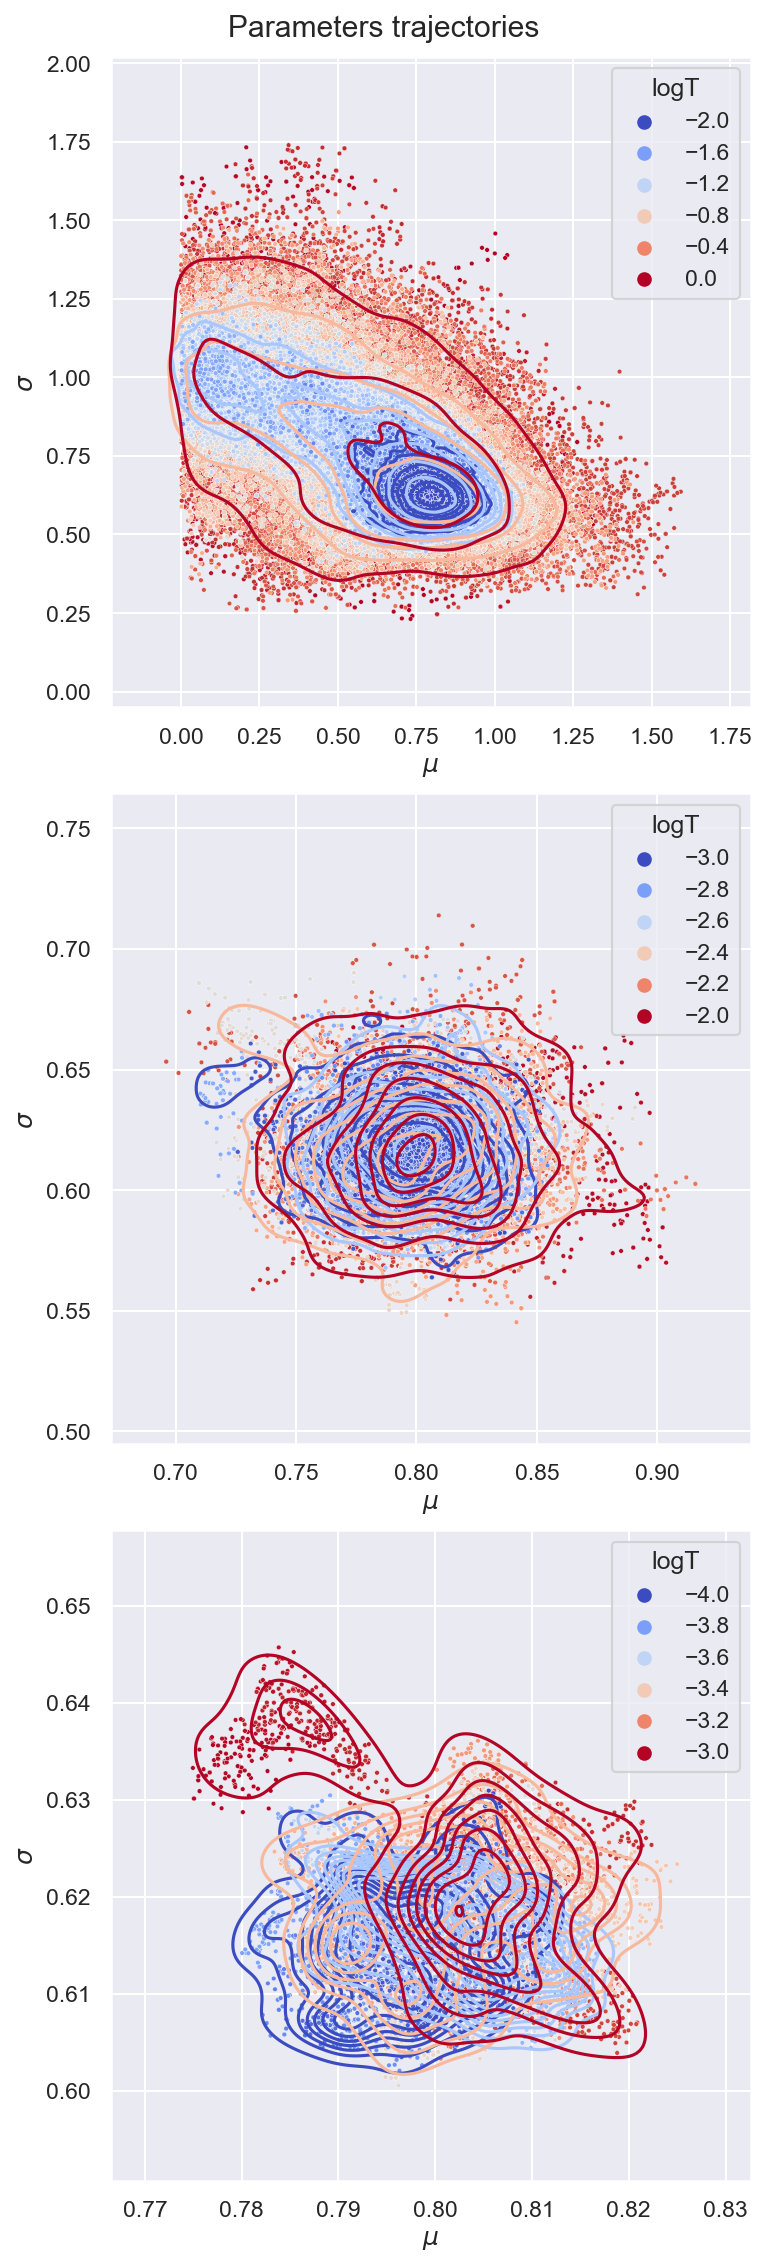

In [3]:
n_rounds = len(hyperparams)-1
# Preparing the matplotlib canvas
fig, axes = plt.subplots(n_rounds, 1, figsize=(
    5, n_rounds*5), constrained_layout=True)
fig.suptitle("Parameters trajectories")
# Running the simulated annealing rounds
for run, (params, ax) in enumerate(zip(hyperparams[:-1], axes)):
    run_simulated_annealing(**params, run=run, use_cached=USE_CACHED)
    annealing_data = read_annealing(run)
    # Setting the same aspect ratio on the axes
    ax.axis("equal")
    # Plotting the sampler trajectory in parameters space, with kernel density estimation
    _ = plot_params_trajectory(annealing_data, kdes=4, ax=ax, s=0.3)
    # Setting the median of the current run (only the last temperature) as a starting point for the next run
    previous_sample_median = annealing_data[[
        "mu", "sigma"]].iloc[-params["n_explore_steps"]:].median()
    hyperparams[run+1]["initial_guess"] = (
        previous_sample_median["mu"], previous_sample_median["sigma"])


The plots show that lowering the temperature improves the guesses (the scatter plots shrink), even while keeping the sampler variance constant.

In [8]:
MU, SIGMA = hyperparams[-1]["initial_guess"]
print("The simulated annealing leads to:")
print(f"µ: {MU}, σ: {SIGMA}")


The simulated annealing leads to:
µ: 0.804452, σ: 0.6272815


### Approximated ground energy estimation and ground state sampling
Estimating the ground energy given the approximated ground state is done computing the energy integral using Monte Carlo techniques. The same goes for the approximate GS sampling, which is performed by the Metropolis algorithm.

In [9]:
# params for the estimation of <H>
N_BLOCKS = 50_000
BLOCK_SIZE = 100
#  params for the histogram of |ψ_GS|²
SAMPLING_BOUND = 3.0
N_BINS = 101
RUN = n_rounds
if not (USE_CACHED and psi_path(RUN).exists() and min_energy_path(RUN).exists()):
    run_estimation(RUN, N_BLOCKS, BLOCK_SIZE,
                   SAMPLING_BOUND, N_BINS, MU, SIGMA)
# Approximated solutions using matrix method
FN_SAMPLES = 1001
E, xs, matrix_psi = compute_states(
    FN_SAMPLES, (-SAMPLING_BOUND, SAMPLING_BOUND))
# Picking the GS
E = E[0]
# normalizing matrix_psi to the central bin (x = 0)
# matrix_psi2 = (matrix_psi[0] / matrix_psi[0, FN_SAMPLES//2])**2
matrix_psi2 = matrix_psi[0]**2


Simulated annealing results:


<IPython.core.display.Latex object>

Matrix method results:


<IPython.core.display.Latex object>

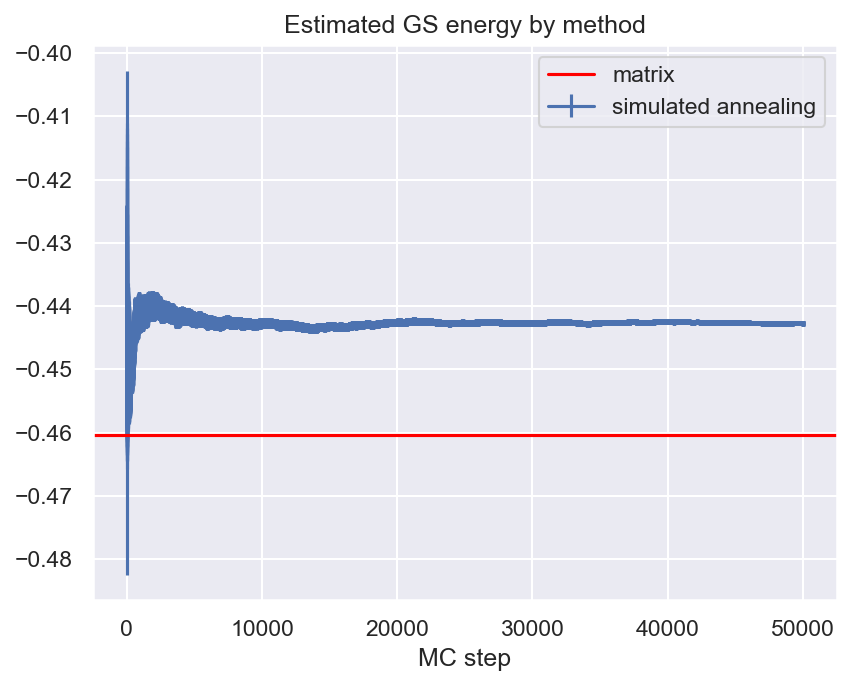

In [10]:
# Plotting the minimum energy data
min_energy_data = read_min_energy(RUN)
ax = min_energy_data.plot(y="H_estimate", yerr="H_error",
                          label="simulated annealing", legend=False)
#  adding the matrix result for comparison
ax.axhline(E, c="red", label="matrix")
ax.set_xlabel("MC step")
ax.set_title("Estimated GS energy by method")
ax.legend()

# Showing the numeric results
H_results = min_energy_data.iloc[-1]
print("Simulated annealing results:")
display(Latex(
    f"$E_{{GS}} = {H_results['H_estimate']:.4f} \pm {H_results['H_error']:.4f}$"))
print("Matrix method results:")
display(Latex(f"$E_{{GS}} = {E:.4f}$"))


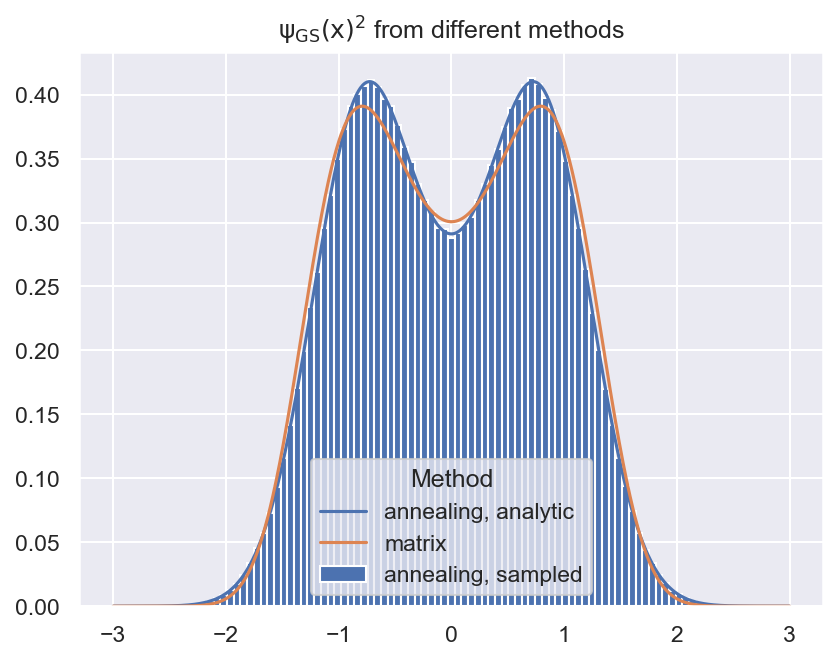

In [11]:
# Plotting the sampled histogram of |ψ_GS(x)|²,
psi2_data = read_psi(RUN)

ax = plot_histogram(psi2_data, label="annealing, sampled")

# Plotting the analitic expression of |ψ_GS(x)|²
annealing_psi2 = make_psi2(MU, SIGMA)(xs)
ax.plot(xs, annealing_psi2, label="annealing, analytic")

# Plotting the result obtained from the matrix method
ax.plot(xs, matrix_psi2, label="matrix")

ax.legend(title="Method")
_ = ax.set_title(r"$\mathrm{\psi_{GS}(x)}^2$ from different methods")
